In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!kaggle datasets download -d swoyam2609/fresh-and-stale-classification

Dataset URL: https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification
License(s): Community Data License Agreement - Permissive - Version 1.0


In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fresh-and-stale-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# New Section

In [7]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
def create_new_dataset(location):
  filename,freshness,fruit=[],[],[]
  for file in tqdm(os.listdir(location)):
    for img in os.listdir(os.path.join(location,file)):
       freshness.append(1 if file[0]=='f' else 0)
       fruit.append(file[5:] if file[0]=='f' else file[6:])
       filename.append(os.path.join(location,file,img))
  df=pd.DataFrame({
      "filename":filename,
      "freshness":freshness,
      "fruit":fruit
  })
  return df
train_dataset=create_new_dataset('/content/dataset/Train')

test_dataset=create_new_dataset('/content/dataset/Test')


100%|██████████| 14/14 [00:00<00:00, 821.54it/s]


In [9]:
train_dataset.sample(10)

,filename,freshness,fruit
21712,/content/dataset/Train/freshbanana/rotated_by_...,1,banana
11341,/content/dataset/Train/rottenbanana/Screen Sho...,0,banana
21402,/content/dataset/Train/freshbanana/rotated_by_...,1,banana
4211,/content/dataset/Train/rottenbittergroud/IMG_2...,0,bittergroud
453,/content/dataset/Train/rottenapples/rotated_by...,0,apples
7141,/content/dataset/Train/freshoranges/saltandpep...,1,oranges
8209,/content/dataset/Train/freshtomato/t_f242.png,1,tomato
11532,/content/dataset/Train/rottenbanana/rotated_by...,0,banana
17405,/content/dataset/Train/rottenoranges/vertical_...,0,oranges
23198,/content/dataset/Train/freshbanana/Screen Shot...,1,banana


In [10]:
train_dataset.shape ,test_dataset.shape

((23619, 3), (6738, 3))

In [11]:
df=pd.concat([train_dataset,test_dataset],axis=0)

In [12]:
df.shape

(30357, 3)

# balancing dataset(In dataset some fruit item number is more then 2000 and some less then 500 )

In [13]:
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns= ['filename', 'fruit', 'freshness'])

for (key, value) in counts.items():
    if value > 1500:
        df_temp = df[df['fruit'] == key].sample(n = 1500)
    else:
        df_temp = df[df['fruit'] == key]

    df_new = pd.concat([df_new, df_temp], axis = 0)

df_new.shape

(13721, 3)

In [14]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df_new['fruit_labeling']=LabelEncoder().fit_transform(df_new['fruit'])
df_new.sample(10)

,filename,fruit,freshness,fruit_labeling
9370,/content/dataset/Train/freshtomato/t_f858.png,tomato,1,10
4777,/content/dataset/Train/rottencapsicum/WhatsApp...,capsicum,0,3
20404,/content/dataset/Train/freshcapsicum/IMG_20200...,capsicum,1,3
9175,/content/dataset/Train/freshtomato/tomato1_38....,tomato,1,10
2975,/content/dataset/Test/freshpatato/p_f153.png,patato,1,7
4321,/content/dataset/Test/freshapples/vertical_fli...,apples,1,0
5163,/content/dataset/Train/rottencapsicum/WhatsApp...,capsicum,0,3
9781,/content/dataset/Train/freshtomato/DSCN4069.jp...,tomato,1,10
4978,/content/dataset/Train/rottencapsicum/WhatsApp...,capsicum,0,3
4801,/content/dataset/Train/rottencapsicum/WhatsApp...,capsicum,0,3


In [41]:
label_to_fruit = df_new[['fruit_labeling', 'fruit']].drop_duplicates().sort_values('fruit_labeling')
print(label_to_fruit)

       fruit_labeling        fruit
642                 0       apples
23556               1       banana
3248                2  bittergroud
4875                3     capsicum
3575                4     cucumber
7843                5         okra
6383                6      oranges
2165                7       patato
5254                8       potato
1243                9        tamto
16327              10       tomato


In [ ]:
df_new.drop('fruit', axis=1, inplace=True)

In [ ]:
df_new['freshness'] = df_new['freshness'].astype(int)


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13721 entries, 198 to 5845
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   filename        13721 non-null  object
 1   freshness       13721 non-null  int64 
 2   fruit_labeling  13721 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [ ]:
df_new['fruit_labeling'].value_counts()

,count
fruit_labeling,
0,1500
1,1500
6,1500
10,1500
3,1500
5,1500
4,1451
8,1338
2,684


In [ ]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(df_new,test_size=0.2,random_state=42)

In [ ]:
train.shape ,test.shape

((10976, 3), (2745, 3))

In [ ]:
train_gendata=ImageDataGenerator(
     rescale=1./255,
     rotation_range=35,
     width_shift_range=0.2,
     height_shift_range=0.2,
     shear_range=0.2,
     zoom_range=0.2,
     horizontal_flip=True
)
test_gendata=ImageDataGenerator(rescale=1./225)

In [ ]:
train_generator=train_gendata.flow_from_dataframe(train ,
                                                  directory = None,
                                                  x_col='filename',
                                                  y_col=['freshness','fruit_labeling'],
                                                  target_size=(200,200),
                                                  class_mode='raw'
                                                  )

test_generator=test_gendata.flow_from_dataframe(test ,
                                                  directory = None,
                                                   x_col='filename',
                                                   y_col=['freshness','fruit_labeling'],
                                                   target_size=(200,200),
                                                  class_mode='raw'
                                                  )


Found 10976 validated image filenames.
Found 2745 validated image filenames.


In [ ]:
# Custom generator function
def custom_generator(generator):
    for x, y in generator:
        # Assuming y is a list of labels
        fruit_labeling= np.array([label[0] for label in y])
        freshness = np.array([label[1] for label in y])
        # Reshape freshness to (batch_size, 1) to match the model's output
        freshness = freshness.reshape((-1, 1))
        yield x, (fruit_labeling, freshness)

def dataset_from_generator(generator, output_signature):
    return tf.data.Dataset.from_generator(generator, output_signature=output_signature)


output_signature = (
    tf.TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32),
    (
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(None,1), dtype=tf.float32)
    )
)
train_gen = dataset_from_generator(lambda: custom_generator(train_generator), output_signature)
test_gen = dataset_from_generator(lambda: custom_generator(test_generator), output_signature)

In [ ]:
from tensorflow.keras.applications import MobileNet
from keras.layers import *
from keras.models import Model

In [ ]:
mobilenet=MobileNet(include_top=False,input_shape=(200,200,3))
mobilenet.trainable=False
output=mobilenet.layers[-1].output

flatter = Flatten()(output)

# ANN for freshness
dense_f1 = Dense(512, activation='relu')(flatter)
dense_f2 = Dense(512, activation='relu')(dense_f1)
output_f = Dense(1, activation='sigmoid', name='freshness')(dense_f2)

# ANN for fruit labeling
dense_fsh1 = Dense(512, activation='relu')(flatter)
dense_fsh2 = Dense(512, activation='relu')(dense_fsh1)
output_fsh = Dense(11, activation='softmax', name='fruit_labeling')(dense_fsh2)
model = keras.Model(inputs=mobilenet.input, outputs=[output_f, output_fsh])

<ipython-input-44-fc236bc08f5f>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet=MobileNet(include_top=False,input_shape=(200,200,3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 100, 100,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        128 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu (ReLU)   │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1           │ (None, 100, 100,  │        288 │ conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_bn        │ (None, 100, 100,  │        128 │ conv_dw_1[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_1_relu      │ (None, 100, 100,  │          0 │ conv_dw_1_bn[0][… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1 (Conv2D)  │ (None, 100, 100,  │      2,048 │ conv_dw_1_relu[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_bn        │ (None, 100, 100,  │        256 │ conv_pw_1[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_1_relu      │ (None, 100, 100,  │          0 │ conv_pw_1_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pad_2          │ (None, 101, 101,  │          0 │ conv_pw_1_relu[0… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2           │ (None, 50, 50,    │        576 │ conv_pad_2[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_bn        │ (None, 50, 50,    │        256 │ conv_dw_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_dw_2_relu      │ (None, 50, 50,    │          0 │ conv_dw_2_bn[0][… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2 (Conv2D)  │ (None, 50, 50,    │      8,192 │ conv_dw_2_relu[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_bn        │ (None, 50, 50,    │        512 │ conv_pw_2[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_pw_2_relu      │ (None, 50, 50,    │          0 │ conv_pw_2_bn[0][

 Total params: 41,510,092 (158.35 MB)

 Trainable params: 38,281,228 (146.03 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
model.compile(optimizer='adam',loss={'freshness':'binary_crossentropy','fruit_labeling': 'sparse_categorical_crossentropy'},metrics={ 'freshness': 'accuracy','fruit_labeling': 'accuracy'} )

In [ ]:
STEP = len(train) // train_generator.batch_size
VALSTEP = len(test) // test_generator.batch_size


In [ ]:
model.fit(train_gen,epochs=5,batch_size=32,validation_data=test_gen,steps_per_epoch=STEP ,validation_steps=VALSTEP)


Epoch 1/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 860s 2s/step - freshness_accuracy: 0.7760 - freshness_loss: 2.0282 - fruit_labeling_accuracy: 0.6733 - fruit_labeling_loss: 4.0119 - loss: 6.0401 - val_freshness_accuracy: 0.8577 - val_freshness_loss: 0.3659 - val_fruit_labeling_accuracy: 0.8871 - val_fruit_labeling_loss: 0.3113 - val_loss: 0.6772
Epoch 2/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 857s 2s/step - freshness_accuracy: 0.9094 - freshness_loss: 0.2203 - fruit_labeling_accuracy: 0.8407 - fruit_labeling_loss: 0.3739 - loss: 0.5942 - val_freshness_accuracy: 0.9415 - val_freshness_loss: 0.1524 - val_fruit_labeling_accuracy: 0.8816 - val_fruit_labeling_loss: 0.3256 - val_loss: 0.4779
Epoch 3/10
343/343 ━━━━━━━━━━━━━━━━━━━━ 863s 3s/step - freshness_accuracy: 0.9323 - freshness_loss: 0.1720 - fruit_labeling_accuracy: 0.8488 - fruit_labeling_loss: 0.3633 - loss: 0.5353 - val_freshness_accuracy: 0.9463 - val_freshness_loss: 0.1469 - val_fruit_labeling_accuracy: 0.8699 - val_fruit_labeling_loss: 0.2966 - 

In [ ]:
import pickle
with open('model.pkl','wb') as f:
  pickle.dump(model,f)


In [ ]:
from google.colab import files


files.download('model.pkl')


In [63]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import pandas as pd
model_path='/content/drive/MyDrive/model.pkl'
# df=pd.read_pickle(file_path)

In [69]:
import pickle
with open(model_path,'rb') as f:
  model=pickle.load(f)

In [90]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(200, 200))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    return img_tensor
img_path='/content/Banana.jpg'
x=load_image(img_path)
output=model.predict(x)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


[array([[0.99998564]], dtype=float32),
 array([[1.03849985e-22, 1.00000000e+00, 1.93688052e-24, 3.21210380e-25,
         2.11892174e-16, 1.94754326e-15, 1.23251072e-22, 1.16995579e-25,
         7.31557968e-21, 1.90647127e-19, 1.03576096e-24]], dtype=float32)]

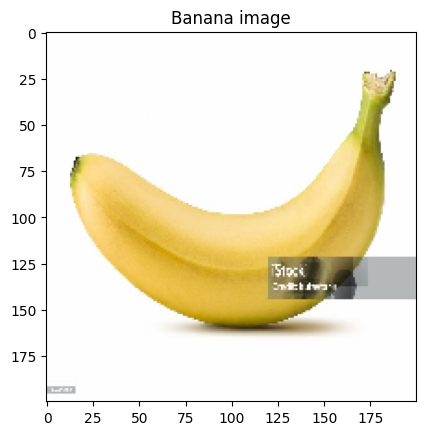

In [91]:
import  matplotlib.pyplot as plt
plt.imshow(x[0])
plt.title('Banana image')
plt.show()




In [93]:
score1=output[0][0][0]
class_labels=['apple','banana', 'bittergroud', 'capsicum', 'cucumber', 'okra',
        'oranges', 'potato', 'potato', 'tomto', 'tomato']
score2=output[1][0]
predict_label=np.argmax(score2)
prediction_label_prob=class_labels[predict_label]

print(f" Fruit Name : {prediction_label_prob}")
if score1>0.5:
  print(f" fruit type : fresh")
else:
  print(f" fruit type :stale")


 Fruit Name : banana
 fruit type : fresh
